In [19]:
import numpy as np
from keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import load_model
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from scipy.stats import ttest_rel
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Bidirectional, GlobalMaxPool1D, LSTM

import prepare_data as prep
from prepare_data import DataPreprocessor
from importlib import reload
import matplotlib.pyplot as plt

reload(prep)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'prepare_data' from 'd:\\Projects\\toxic-comment-classification\\prepare_data.py'>

In [2]:
prepData = DataPreprocessor("jigsaw-toxic-comment-classification-challenge/train.csv")

prepData.load_data()
prepData.preprocess_data()
X, y = prepData.get_XY()

                      id                                       comment_text  \
0       0000997932d777bf  explanation\nwhy the edits made under my usern...   
1       000103f0d9cfb60f  d'aww! he matches this background colour i'm s...   
2       000113f07ec002fd  hey man, i'm really not trying to edit war. it...   
3       0001b41b1c6bb37e  "\nmore\ni can't make any real suggestions on ...   
4       0001d958c54c6e35  you, sir, are my hero. any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::and for the second time of asking, when ...   
159567  ffea4adeee384e90  you should be ashamed of yourself \n\nthat is ...   
159568  ffee36eab5c267c9  spitzer \n\numm, theres no actual article for ...   
159569  fff125370e4aaaf3  and it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nand ... i really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insul

In [3]:
# Zmniana wartości klas w binarne

mlb = LabelBinarizer()
y_binary = mlb.fit_transform(y)

X_notoken = X

# Tokenizacja danych tekstowych
max_words = 20000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len)

# Podział metodą train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_binary, test_size=0.2, random_state=42)

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train2=X_train[::10]
y_train2=y_train[::10]
X_test2=X_test[::10]
y_test2=y_test[::10]

print("X_train2", X_train2.shape)
print("X_test2", X_test2.shape)
print("y_train2", y_train2.shape)
print("y_test2", y_test2.shape)

X_train (127656, 150)
X_test (31915, 150)
y_train (127656, 6)
y_test (31915, 6)
X_train2 (12766, 150)
X_test2 (3192, 150)
y_train2 (12766, 6)
y_test2 (3192, 6)


CNN HYPERPARAMETERS

In [11]:
space = {
    'max_len': hp.choice('max_len', [100, 200, 300]),
    'embed_dim': hp.choice('embed_dim', [64, 128, 256]),
    'filters': hp.choice('filters', [64, 128, 256]),
    'kernel_size': hp.choice('kernel_size', [3, 5, 7]),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'epochs': hp.choice('epochs', [3]),
}

def pad_sequences_custom(sequences, max_len):
    return np.array([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in sequences])

def objective(params):
    # Cross-validation setup
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores_cnn = []
    
    # Define the CNN model
    inputs = Input(shape=(params['max_len'],))
    embedding = Embedding(input_dim=max_words, output_dim=params['embed_dim'], input_length=params['max_len'])(inputs)
    conv1 = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu')(pool1)
    pool2 = GlobalMaxPooling1D()(conv2)
    dense1 = Dense(params['dense_units'], activation='relu')(pool2)
    dropout = Dropout(params['dropout_rate'])(dense1)
    outputs = Dense(6, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    for train_index, val_index in kf.split(X_train2):
        print(train_index)
        X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
        y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]

        # Adjust the input data to match max_len
        X_train_fold = pad_sequences_custom(X_train_fold, params['max_len'])
        X_val_fold = pad_sequences_custom(X_val_fold, params['max_len'])
        
        # Define callbacks
        checkpoint = ModelCheckpoint('best_model_cnn.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

        # Train the model
        history_cnn = model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

        # Evaluate the model
        val_preds = model.predict(X_val_fold)
        val_preds_binary = (val_preds > 0.5).astype(int)
        f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
        val_scores_cnn.append(f1)

    # Calculate the average F1 score over all folds
    avg_f1 = np.mean(val_scores_cnn)
    
    # Return the negative average F1 score to minimize
    return {'loss': -avg_f1, 'status': STATUS_OK}

# Initialize Trials object to keep track of results
trials = Trials()

# Run hyperparameter optimization
best_cnn = fmin(objective, space, algo=tpe.rand.suggest, max_evals=2, trials=trials)

# Print the best hyperparameters
print('Best hyperparameters:', best_cnn)

[    1     2     4 ... 12758 12763 12765]            
Epoch 1/3                                            

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.3125 - loss: 0.6994
 3/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3212 - loss: 0.6877
 5/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3363 - loss: 0.6747
 7/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3385 - loss: 0.6562
 9/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3378 - loss: 0.6326
11/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3362 - loss: 0.6075
13/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3338 - loss: 0.5846
15/67 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3306 - loss: 0.5640
17/67 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3277 - loss: 0.5465
19/67 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3255 - loss: 0.5302
21/67 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3250 - loss: 0.5157
23/67 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3261 - loss: 0.5023
25/

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                                                       

  1/266 ━━━━━━━━━━━━━━━━━━━━ 4:51 1s/step - accuracy: 0.6875 - loss: 0.6960
  5/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7260 - loss: 0.6772
  9/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7009 - loss: 0.6405
 13/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6745 - loss: 0.5827
 16/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6602 - loss: 0.5473
 20/266 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6565 - loss: 0.5103
 23/266 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6605 - loss: 0.4874
 26/266 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6655 - loss: 0.4668
 29/266 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6688 - loss: 0.4486
 32/266 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6687 - loss: 0.4329
 35/266 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6666 - loss: 0.4193
 38/266 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6636 - loss: 0.4072
 41/26

LSTM HYPERPARAMETERS

In [12]:
space = {
    'max_len': hp.choice('max_len', [100, 200, 300]),
    'embed_dim': hp.choice('embed_dim', [64, 128, 256]),
    'lstm_units': hp.choice('lstm_units', [32, 64, 128]),
    'recurrent_dropout': hp.uniform('recurrent_dropout', 0.1, 0.3),
    'dense_units': hp.choice('dense_units', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.4),
    'batch_size': hp.choice('batch_size', [64, 128, 256]),
    'epochs': hp.choice('epochs', [3]),
}

def objective(params):
    # Cross-validation setup
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores_lstm = []
    inputs = Input(shape=(params['max_len'],))
    layer = Embedding(input_dim=max_words, output_dim=params['embed_dim'], input_length=params['max_len'])(inputs)
    layer = Bidirectional(LSTM(params['lstm_units'], return_sequences=True, recurrent_dropout=params['recurrent_dropout']))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(params['dropout_rate'])(layer)
    layer = Dense(params['dense_units'], activation='relu')(layer)
    layer = Dropout(params['dropout_rate'])(layer)
    layer = Dense(6, activation='sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    for train_index, val_index in kf.split(X_train2):
        X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
        y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]

        # Adjust the input data to match max_len
        X_train_fold = pad_sequences_custom(X_train_fold, params['max_len'])
        X_val_fold = pad_sequences_custom(X_val_fold, params['max_len'])
    
        checkpoint = ModelCheckpoint('save_best_model_lstm.keras', monitor='val_loss', verbose=1, save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=1)

        history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2, callbacks=[checkpoint, early_stop])

        # Evaluate the model
        val_preds = model.predict(X_val_fold)
        val_preds_binary = (val_preds > 0.5).astype(int)
        f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
        val_scores_lstm.append(f1)

    # Calculate the average F1 score over all folds
    avg_f1 = np.mean(val_scores_lstm)

    return {'loss': -avg_f1, 'status': STATUS_OK}

trials = Trials()

best_lstm = fmin(objective, space, algo=tpe.rand.suggest, max_evals=2, trials=trials)

print('Best hyperparameters:', best_lstm)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                            

 1/54 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - accuracy: 0.2812 - loss: 0.6907
 2/54 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2500 - loss: 0.6889
 3/54 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.2335 - loss: 0.6872
 4/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2225 - loss: 0.6853
 5/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2158 - loss: 0.6831
 6/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2122 - loss: 0.6807
 7/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2106 - loss: 0.6780
 8/54 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2099 - loss: 0.6749
 9/54 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2099 - loss: 0.6715
10/54 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2110 - loss: 0.6679
11/54 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2126 - loss: 0.6640
12/54 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2138 - loss: 0.6597
13/54 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.214

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                                                       

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.0586 - loss: 0.6962
 2/27 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.0781 - loss: 0.6923
 3/27 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.1020 - loss: 0.6881
 4/27 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.1285 - loss: 0.6831
 5/27 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.1492 - loss: 0.6771
 6/27 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.1669 - loss: 0.6702
 7/27 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.1806 - loss: 0.6623
 8/27 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.1907 - loss: 0.6535
 9/27 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.1981 - loss: 0.6441
10/27 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.2032 - loss: 0.6341
11/27 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.2067 - loss: 0.6237
12/27 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.2090 - loss: 0.6132
13/27 ━━━━━━━━━━━━━

HYPERPARAMETERS PRINT

In [13]:
# Map best indices to actual values
best_cnn['max_len'] = [100, 200, 300][best_cnn['max_len']]
best_cnn['embed_dim'] = [64, 128, 256][best_cnn['embed_dim']]
best_cnn['kernel_size'] = [3, 5, 7][best_cnn['kernel_size']]
best_cnn['filters'] = [64, 128, 256][best_cnn['filters']]
best_cnn['dense_units'] = [32, 64, 128][best_cnn['dense_units']]
best_cnn['batch_size'] = [64, 128, 256][best_cnn['batch_size']]
best_cnn['epochs'] = [3][best_cnn['epochs']]  # Only one choice, but maintaining structure

print('Best hyperparameters CNN:', best_cnn)

# Map best indices to actual values
best_lstm['max_len'] = [100, 200, 300][best_lstm['max_len']]
best_lstm['embed_dim'] = [64, 128, 256][best_lstm['embed_dim']]
best_lstm['lstm_units'] = [32, 64, 128][best_lstm['lstm_units']]
best_lstm['dense_units'] = [32, 64, 128][best_lstm['dense_units']]
best_lstm['batch_size'] = [64, 128, 256][best_lstm['batch_size']]
best_lstm['epochs'] = [3][best_lstm['epochs']]  # Only one choice, but maintaining structure

print('Best hyperparameters LSTM:', best_lstm)

Best hyperparameters CNN: {'batch_size': 64, 'dense_units': 128, 'dropout_rate': 0.34528970070935183, 'embed_dim': 128, 'epochs': 3, 'filters': 64, 'kernel_size': 7, 'max_len': 200}
Best hyperparameters LSTM: {'batch_size': 256, 'dense_units': 128, 'dropout_rate': 0.16967693363455327, 'embed_dim': 128, 'epochs': 3, 'lstm_units': 64, 'max_len': 200, 'recurrent_dropout': 0.15077201752726585}


LSTM

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[     1      2      4 ... 127652 127653 127655]
Epoch 1/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6006 - loss: 0.2082
Epoch 1: val_loss improved from inf to 0.05171, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 60s 90ms/step - accuracy: 0.6010 - loss: 0.2079 - val_accuracy: 0.9945 - val_loss: 0.0517
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9123 - loss: 0.0551
Epoch 2: val_loss improved from 0.05171 to 0.05103, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.9124 - loss: 0.0551 - val_accuracy: 0.9945 - val_loss: 0.0510
Epoch 3/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9534 - loss: 0.0468
Epoch 3: val_loss improved from 0.05103 to 0.05098, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.9534 - loss: 0.0468 - val_accuracy: 0.9945 - val_loss: 0.0510
Epoch 4/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - ac

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      2 ... 127653 127654 127655]
Epoch 1/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9752 - loss: 0.0428
Epoch 1: val_loss improved from inf to 0.05307, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.9752 - loss: 0.0428 - val_accuracy: 0.9943 - val_loss: 0.0531
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9668 - loss: 0.0374
Epoch 2: val_loss did not improve from 0.05307
639/639 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.9668 - loss: 0.0374 - val_accuracy: 0.9943 - val_loss: 0.0562
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      2      3 ... 127651 127653 127654]
Epoch 1/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9574 - loss: 0.0357
Epoch 1: val_loss improved from inf to 0.05534, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9574 - loss: 0.0357 - val_accuracy: 0.9938 - val_loss: 0.0553
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9303 - loss: 0.0324
Epoch 2: val_loss did not improve from 0.05534
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.9303 - loss: 0.0324 - val_accuracy: 0.9938 - val_loss: 0.0637
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      2 ... 127652 127654 127655]
Epoch 1/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9258 - loss: 0.0321
Epoch 1: val_loss improved from inf to 0.06063, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.9258 - loss: 0.0321 - val_accuracy: 0.9939 - val_loss: 0.0606
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8882 - loss: 0.0286
Epoch 2: val_loss did not improve from 0.06063
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.8882 - loss: 0.0286 - val_accuracy: 0.9804 - val_loss: 0.0664
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      3 ... 127653 127654 127655]
Epoch 1/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8080 - loss: 0.0277
Epoch 1: val_loss improved from inf to 0.06696, saving model to save_best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.8080 - loss: 0.0277 - val_accuracy: 0.9918 - val_loss: 0.0670
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8316 - loss: 0.0253
Epoch 2: val_loss did not improve from 0.06696
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.8314 - loss: 0.0253 - val_accuracy: 0.9590 - val_loss: 0.0754
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


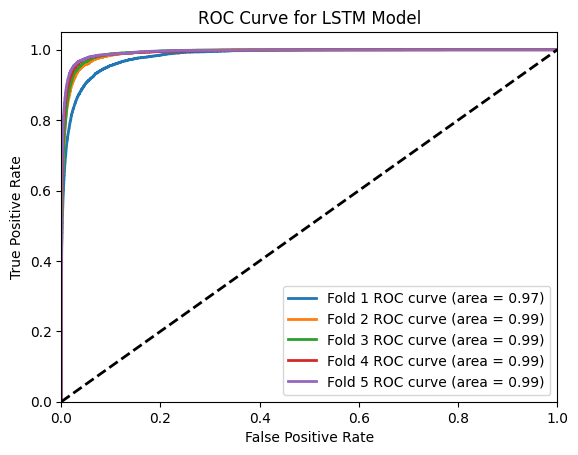

In [14]:

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores_lstm = []
inputs = Input(shape=(200,))
layer = Embedding(input_dim=max_words, output_dim=128, input_length=200)(inputs)
layer = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.28))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.30)(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dropout(0.30)(layer)
layer = Dense(6, activation='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_val_scores_f1 = []
lstm_val_scores_precision = []
lstm_val_scores_recall = []
lstm_val_scores_accuracy = []
lstm_roc_auc = []
lstm_fpr = []
lstm_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)

    checkpoint = ModelCheckpoint('save_best_model_lstm.keras', monitor='val_loss', verbose=1, save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=1)

    history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=128, epochs=5, validation_split=0.2, callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    lstm_val_scores_f1.append(f1)
    lstm_val_scores_precision.append(precision)
    lstm_val_scores_recall.append(recall)
    lstm_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    lstm_roc_auc.append(auc)
    lstm_fpr.append(fpr)
    lstm_tpr.append(tpr)


# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(lstm_fpr)):  # Each fold
    plt.plot(lstm_fpr[i], lstm_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {lstm_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()

CNN

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[     1      2      4 ... 127652 127653 127655]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7669 - loss: 0.1284
Epoch 1: val_loss improved from inf to 0.05275, saving model to best_model_cnn.keras
798/798 ━━━━━━━━━━━━━━━━━━━━ 113s 140ms/step - accuracy: 0.7670 - loss: 0.1283 - val_accuracy: 0.9941 - val_loss: 0.0528
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9528 - loss: 0.0467
Epoch 2: val_loss improved from 0.05275 to 0.05203, saving model to best_model_cnn.keras
798/798 ━━━━━━━━━━━━━━━━━━━━ 112s 140ms/step - accuracy: 0.9528 - loss: 0.0467 - val_accuracy: 0.9940 - val_loss: 0.0520
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9546 - loss: 0.0357
Epoch 3: val_loss did not improve from 0.05203
798/798 ━━━━━━━━━━━━━━━━━━━━ 106s 133ms/step - accuracy: 0.9546 - loss: 0.0357 - val_accuracy: 0.9941 - val_loss: 0.0557
Epoch 4/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8950 - loss: 0.0290
Epoch 4: val_loss di

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      2 ... 127653 127654 127655]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9027 - loss: 0.0341
Epoch 1: val_loss improved from inf to 0.02567, saving model to best_model_cnn.keras
798/798 ━━━━━━━━━━━━━━━━━━━━ 110s 138ms/step - accuracy: 0.9027 - loss: 0.0341 - val_accuracy: 0.9930 - val_loss: 0.0257
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9126 - loss: 0.0242
Epoch 2: val_loss did not improve from 0.02567
798/798 ━━━━━━━━━━━━━━━━━━━━ 108s 135ms/step - accuracy: 0.9125 - loss: 0.0242 - val_accuracy: 0.9887 - val_loss: 0.0272
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7432 - loss: 0.0191
Epoch 3: val_loss did not improve from 0.02567
798/798 ━━━━━━━━━━━━━━━━━━━━ 110s 138ms/step - accuracy: 0.7431 - loss: 0.0191 - val_accuracy: 0.6120 - val_loss: 0.0303
Epoch 3: early stopping
798/798 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
[     0      2      3 ... 127651 127653 127654]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━

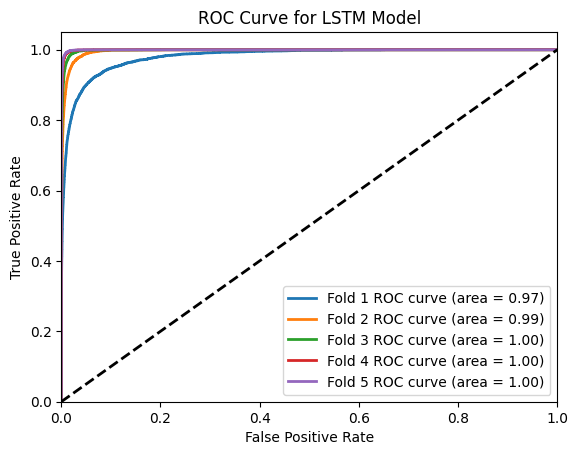

In [16]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores_cnn = []

# Define the CNN model
inputs = Input(shape=(200,))
embedding = Embedding(input_dim=max_words, output_dim=256, input_length=200)(inputs)
conv1 = Conv1D(filters=256, kernel_size=3, activation='relu')(embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=256, kernel_size=3, activation='relu')(pool1)
pool2 = GlobalMaxPooling1D()(conv2)
dense1 = Dense(64, activation='relu')(pool2)
dropout = Dropout(0.20)(dense1)
outputs = Dense(6, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_val_scores_f1 = []
cnn_val_scores_precision = []
cnn_val_scores_recall = []
cnn_val_scores_accuracy = []
cnn_roc_auc = []
cnn_fpr = []
cnn_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)
    
    # Define callbacks
    checkpoint = ModelCheckpoint('best_model_cnn.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

    # Train the model
    history_cnn = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=128, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)

    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    cnn_val_scores_f1.append(f1)
    cnn_val_scores_precision.append(precision)
    cnn_val_scores_recall.append(recall)
    cnn_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    cnn_roc_auc.append(auc)
    cnn_fpr.append(fpr)
    cnn_tpr.append(tpr)

# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(cnn_fpr)):  # Each fold
    plt.plot(cnn_fpr[i], cnn_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {cnn_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()
    

998/998 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
Test F1 Score: 0.5712988015219976
Test Precision: 0.6132277037048253
Test Recall: 0.536473042554639
Test Accuracy: 0.9076609744634184
Test ROC AUC: 0.9653025395641762


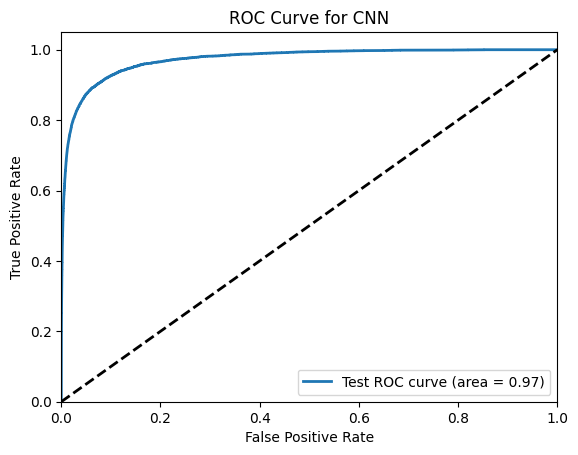

In [20]:
#CNN
# Test the model on X_test
best_model = load_model('best_model_cnn.keras')
X_test_padded = pad_sequences_custom(X_test, 200)
test_preds = best_model.predict(X_test_padded)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test, test_preds_binary, average='macro')
test_precision = precision_score(y_test, test_preds_binary, average='macro')
test_recall = recall_score(y_test, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Plot ROC curve for test data
test_fpr, test_tpr, _ = roc_curve(y_test.ravel(), test_preds.ravel())
plt.figure()
plt.plot(test_fpr, test_tpr, lw=2, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()

998/998 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
Test F1 Score: 0.48739284021164736
Test Precision: 0.5617521484644361
Test Recall: 0.4509094071526894
Test Accuracy: 0.9109196302678991
Test ROC AUC: 0.9704515118413731


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


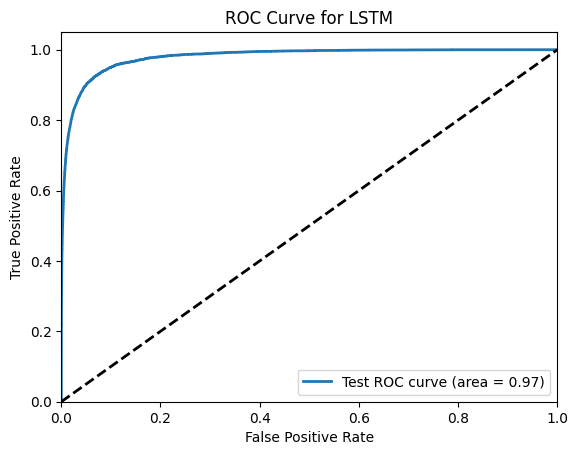

In [21]:
#LSTM
# Test the model on X_test
best_model = load_model('save_best_model_lstm.keras')
X_test_padded = pad_sequences_custom(X_test, 200)
test_preds = best_model.predict(X_test_padded)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test, test_preds_binary, average='macro')
test_precision = precision_score(y_test, test_preds_binary, average='macro')
test_recall = recall_score(y_test, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Plot ROC curve for test data
test_fpr, test_tpr, _ = roc_curve(y_test.ravel(), test_preds.ravel())
plt.figure()
plt.plot(test_fpr, test_tpr, lw=2, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM')
plt.legend(loc="lower right")
plt.show()

Best parameters from RandomizedSearchCV: {'estimator__C': 9.51714306409916, 'estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.86      0.67      0.76     12238
           1       0.53      0.30      0.38      1274
           2       0.88      0.69      0.77      6734
           3       0.63      0.25      0.35       404
           4       0.77      0.56      0.65      6263
           5       0.59      0.28      0.38      1111

   micro avg       0.83      0.61      0.70     28024
   macro avg       0.71      0.46      0.55     28024
weighted avg       0.82      0.61      0.70     28024
 samples avg       0.06      0.05      0.05     28024

Test F1 Score: 0.5366574946940555
Test Precision: 0.707395652172469
Test Recall: 0.4449992962863825
Test Accuracy: 0.918314272285759
Test ROC AUC: 0.7201315752393777


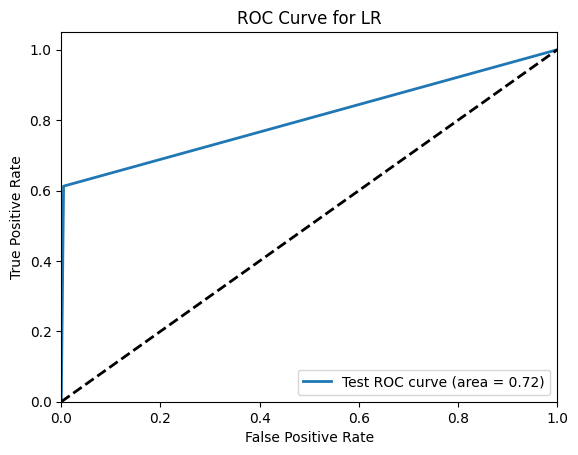

In [39]:
def LR_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]
    
    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)
    
    random_search_LR.fit(X_vec, y_label)
    best_params = random_search_LR.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    # Clean the best parameters
    cleaned_params = remove_prefix(best_params)
    
    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    all_predictions = []
    all_y_tests = []
    modelLR = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True, **cleaned_params))

    for train_index, test_index in kf.split(X_padded):
        X_train_LR, X_test_LR = X_padded[train_index], X_padded[test_index]
        y_train_LR, y_test_LR = y_label[train_index], y_label[test_index]
        
        X_train_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_LR]
        X_test_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_LR]
        
        X_train_LR_vec = tfidf_vec.fit_transform(X_train_LR)
        X_test_LR_vec = tfidf_vec.transform(X_test_LR)
        
        modelLR.fit(X_train_LR_vec, y_train_LR)
        
        predictions = modelLR.predict(X_test_LR_vec)
        
        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_LR)
    
    # Print classification report
    print(classification_report(all_y_tests, all_predictions, zero_division=0))
    accuracy = accuracy_score(all_y_tests, all_predictions)
    report = classification_report(all_y_tests, all_predictions, output_dict=True, zero_division=0)

    return modelLR, tfidf_vec

# Trenuj model LR
modelLR, tfidf_vec_LR = LR_Training_CV(y_train, X_train, tokenizer)

# Przygotowanie danych testowych
X_test_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test]
X_test_vec = tfidf_vec_LR.transform(X_test_text)

# Dokonaj predykcji na danych testowych
test_preds = modelLR.predict(X_test_vec)
test_preds_binary = (test_preds > 0.5).astype(int)

# Oblicz metryki na danych testowych
test_f1 = f1_score(y_test, test_preds_binary, average='macro')
test_precision = precision_score(y_test, test_preds_binary, average='macro')
test_recall = recall_score(y_test, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Oblicz krzywą ROC dla danych testowych
test_fpr, test_tpr, _ = roc_curve(y_test.ravel(), test_preds.ravel())

# Narysuj krzywą ROC dla danych testowych
plt.figure()
plt.plot(test_fpr, test_tpr, lw=2, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LR')
plt.legend(loc="lower right")
plt.show()


Best parameters from RandomizedSearchCV: {'estimator__alpha': 0.3745401188473625, 'estimator__fit_prior': True}
              precision    recall  f1-score   support

           0       0.91      0.51      0.66     12238
           1       0.64      0.09      0.16      1274
           2       0.89      0.51      0.65      6734
           3       0.50      0.00      0.00       404
           4       0.82      0.43      0.56      6263
           5       0.75      0.04      0.08      1111

   micro avg       0.88      0.45      0.59     28024
   macro avg       0.75      0.26      0.35     28024
weighted avg       0.86      0.45      0.58     28024
 samples avg       0.05      0.04      0.04     28024

Accuracy: 0.9117706962461616
Test F1 Score: 0.34663375514746925
Test Precision: 0.6374501335119936
Test Recall: 0.2586132538700364
Test Accuracy: 0.9101362995456682
Test ROC AUC: 0.6280719331098885


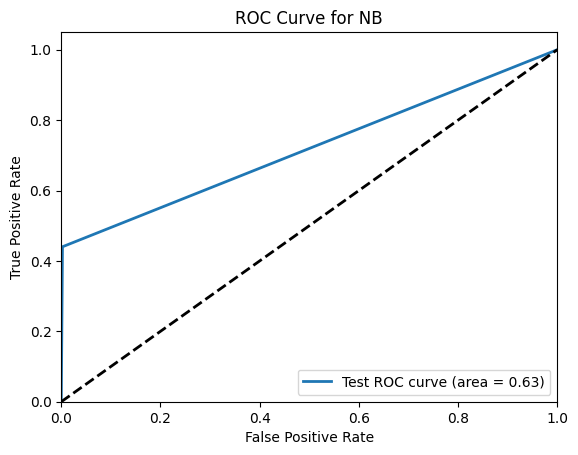

In [40]:
def NB_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]

    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)

    random_search_NB.fit(X_vec, y_label)
    best_params = random_search_NB.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    cleaned_params = remove_prefix(best_params)

    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_predictions = []
    all_y_tests = []
    modelNB = MultiOutputClassifier(MultinomialNB(**cleaned_params))
    for train_index, test_index in kf.split(X_padded):
        X_train_NB, X_test_NB = X_padded[train_index], X_padded[test_index]
        y_train_NB, y_test_NB = y_label[train_index], y_label[test_index]

        X_train_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_NB]
        X_test_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_NB]

        X_train_NB_vec = tfidf_vec.fit_transform(X_train_NB)
        X_test_NB_vec = tfidf_vec.transform(X_test_NB)

        modelNB.fit(X_train_NB_vec, y_train_NB)

        predictions = modelNB.predict(X_test_NB_vec)

        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_NB)

    # Print classification report
    print(classification_report(all_y_tests, all_predictions, zero_division=0))
    
    # Calculate and return metrics
    report = classification_report(all_y_tests, all_predictions, output_dict=True, zero_division=0)
    accuracy = accuracy_score(all_y_tests, all_predictions)
    print('Accuracy:', accuracy)
    return modelNB, tfidf_vec

# Trenuj model NB
modelNB, tfidf_vec_NB = NB_Training_CV(y_train, X_train, tokenizer)

# Przygotowanie danych testowych
X_test_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test]
X_test_vec = tfidf_vec_NB.transform(X_test_text)

# Dokonaj predykcji na danych testowych
test_preds = modelNB.predict(X_test_vec)
test_preds_binary = (test_preds > 0.5).astype(int)

# Oblicz metryki na danych testowych
test_f1 = f1_score(y_test, test_preds_binary, average='macro')
test_precision = precision_score(y_test, test_preds_binary, average='macro')
test_recall = recall_score(y_test, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Oblicz krzywą ROC dla danych testowych
test_fpr, test_tpr, _ = roc_curve(y_test.ravel(), test_preds.ravel())

# Narysuj krzywą ROC dla danych testowych
plt.figure()
plt.plot(test_fpr, test_tpr, lw=2, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NB')
plt.legend(loc="lower right")
plt.show()


In [42]:
results_metrics = {
    'Regresja_Liniowa': {
        'accuracy': [],
        'precision': [ 0.86, 0.53, 0.88, 0.63, 0.77],
        'recall': [0.67, 0.30, 0.69, 0.25, 0.56],
        'f1_score': [0.76, 0.38, 0.77, 0.35, 0.65]
    },
    'Naive_Bayes': {
        'accuracy': [],
        'precision': [0.91, 0.64, 0.89, 0.82, 0.75],
        'recall': [0.51, 0.09, 0.51, 0.43, 0.04],
        'f1_score': [0.66, 0.16, 0.65, 0.56, 0.08]
    },
    'CNN': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    },
    'LSTM': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
}

results_metrics['LSTM']['accuracy']=lstm_val_scores_accuracy
results_metrics['LSTM']['precision']=lstm_val_scores_precision
results_metrics['LSTM']['recall']=lstm_val_scores_recall
results_metrics['LSTM']['f1_score']=lstm_val_scores_f1

results_metrics['CNN']['accuracy']=cnn_val_scores_accuracy
results_metrics['CNN']['precision']=cnn_val_scores_precision
results_metrics['CNN']['recall']=cnn_val_scores_recall
results_metrics['CNN']['f1_score']=cnn_val_scores_f1

print(results_metrics)

{'Regresja_Liniowa': {'accuracy': [], 'precision': [0.86, 0.53, 0.88, 0.63, 0.77], 'recall': [0.67, 0.3, 0.69, 0.25, 0.56], 'f1_score': [0.76, 0.38, 0.77, 0.35, 0.65]}, 'Naive_Bayes': {'accuracy': [], 'precision': [0.91, 0.64, 0.89, 0.82, 0.75], 'recall': [0.51, 0.09, 0.51, 0.43, 0.04], 'f1_score': [0.66, 0.16, 0.65, 0.56, 0.08]}, 'CNN': {'accuracy': [0.909446968510105, 0.9459872312091183, 0.962711997179899, 0.9738748971838157, 0.9788884101680311], 'precision': [0.5682840393390419, 0.7705761274952277, 0.8369694631431884, 0.8570040943402709, 0.8740826784782721], 'recall': [0.4035948599525498, 0.5990269459839483, 0.727116946464529, 0.7834437727022876, 0.9126931280183367], 'f1_score': [0.4502058470011887, 0.6487376450018298, 0.7743929402704538, 0.8129748109763056, 0.890271085828155]}, 'LSTM': {'accuracy': [0.9147736174212753, 0.9305941796247699, 0.9309075241862833, 0.9422270964709569, 0.9473972817359289], 'precision': [0.49556576969305666, 0.5917346314211, 0.6333455367938327, 0.6379573132

In [45]:
def perform_t_tests_to_df(results_metrics, metric):
    models = list(results_metrics.keys())
    n_models = len(models)
    results = []

    for i in range(n_models):
        for j in range(i + 1, n_models):
            model_1 = models[i]
            model_2 = models[j]
            scores_1 = results_metrics[model_1][metric]
            scores_2 = results_metrics[model_2][metric]
            t_stat, p_value = ttest_rel(scores_1, scores_2)
            results.append({
                'Metric': metric,
                'Model 1': model_1,
                'Model 2': model_2,
                't-stat': t_stat,
                'p-value': p_value
            })

    return pd.DataFrame(results)

# Przeprowadzenie t-testów dla precision, recall i f1-score i zapis wyników do DataFrame
df_precision = perform_t_tests_to_df(results_metrics, 'precision')
df_recall = perform_t_tests_to_df(results_metrics, 'recall')
df_f1_score = perform_t_tests_to_df(results_metrics, 'f1_score')

# Połączenie wyników w jeden DataFrame
df_results = pd.concat([df_precision, df_recall, df_f1_score], ignore_index=True)

# Zapis wyników do pliku LaTeX
latex_table = df_results.to_latex(index=False, float_format="%.4f")

print(latex_table)

# Zapis tabeli LaTeX do pliku
with open('t_test_results.tex', 'w') as f:
    f.write(latex_table)

\begin{tabular}{lllrr}
\toprule
Metric & Model 1 & Model 2 & t-stat & p-value \\
\midrule
precision & Regresja_Liniowa & Naive_Bayes & -1.8148 & 0.1437 \\
precision & Regresja_Liniowa & CNN & -0.4787 & 0.6572 \\
precision & Regresja_Liniowa & LSTM & 1.6437 & 0.1756 \\
precision & Naive_Bayes & CNN & 0.2371 & 0.8243 \\
precision & Naive_Bayes & LSTM & 3.0339 & 0.0386 \\
precision & CNN & LSTM & 6.5646 & 0.0028 \\
recall & Regresja_Liniowa & Naive_Bayes & 1.6034 & 0.1841 \\
recall & Regresja_Liniowa & CNN & -1.3726 & 0.2418 \\
recall & Regresja_Liniowa & LSTM & 0.2718 & 0.7992 \\
recall & Naive_Bayes & CNN & -2.2837 & 0.0844 \\
recall & Naive_Bayes & LSTM & -1.2314 & 0.2856 \\
recall & CNN & LSTM & 3.7518 & 0.0199 \\
f1_score & Regresja_Liniowa & Naive_Bayes & 1.2773 & 0.2706 \\
f1_score & Regresja_Liniowa & CNN & -1.0057 & 0.3714 \\
f1_score & Regresja_Liniowa & LSTM & 0.6876 & 0.5295 \\
f1_score & Naive_Bayes & CNN & -1.7096 & 0.1625 \\
f1_score & Naive_Bayes & LSTM & -0.6260 & 0.5652 